<a href="https://colab.research.google.com/github/victorccard/Portfolio/blob/main/ForecastPrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Price Optimization**

A machine learning algorithm will be created. The results of the algorithm are recommended prices for the next period that maximize the company's profits = total sales x (price - cost per unit). In each period, it has accurate forecasts of market conditions and its cost per unit in the next period. It also has detailed information about the present and the past: current and past market conditions, current and past own and competitors' prices, current and past own costs per unit, current and past own sales, and market share performance. You can use new inputs/features or combinations of inputs/features in the algorithm.

To design and train the algorithm, you have data from 55 markets. For each period (day) and market in the training data, you observe the price of the firm you are asked to optimize, its costs per unit, its total units sold (normalized), its share of sales in that period, an average of competitors' prices, and a variable summarizing the market conditions in that period (on a scale between 0 and 100). A period and market identifier are also noted. A detailed description of the variables in the raw data follows.

There is no need to build a development interface, but the Python code should have several functions clearly marked:

process_training_data() - a function that takes the raw data and processes it to generate the inputs needed to train the model.
train_model() - a function that takes the inputs and trains the model.
predict_price() - a function that takes new inputs and the trained model as arguments, and recommends a new price for the next period.
Any pricing algorithms that companies implement may be subject to inspection and regulation by antitrust authorities, which are increasingly concerned with algorithmic coordination. Examples of coordination include algorithms that learn to "team up" with competitors and coordinate the maintenance of high prices by punishing, or threatening to punish, competitors' price reductions by further reducing their own price. Please take this into consideration when developing your algorithm.


Variables Dictionary

- “Mkt_id” - identifier for the market 
- “Output_date” - identifier for the period (day) 
- “Output_own_price” - own price set in the period (day)
- “Output_own_cost” - own per-unit cost of goods sold for the period
- “Output_comp_price” - average of competitor prices in the period
- “Output_X” - a variable summarizing market conditions in the period (on a scale between 0 and 100) 
- “Output_own_sales” - own sales in the period 
- “Output_own_share” - own sales share in the period 
- “Output_own_profits” - own total profits in the period



In [1]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import scipy.stats as stats

In [2]:
# Load the dataset.
df = pd.read_csv("output_data.csv")

# Convert the 'output_date' column to date type.
df['output_date'] = pd.to_datetime(df['output_date'])

# Create a new column called 'day' that extracts the day from the 'output_date' column.
df["day"]=df["output_date"].dt.day

In [3]:
# Displays the first rows of dataset.
df.head()

,mkt_id,output_date,output_own_price,output_own_cost,output_comp_price,output_own_profits,output_X,output_own_share,output_own_sales,day
0,44,2019-01-01,7.05,5.90,7.11,15.06500,42.80,0.515267,13.10,1
1,44,2019-01-02,7.05,6.05,7.11,24.31000,36.14,0.557082,24.31,2
2,44,2019-01-03,7.05,5.98,7.28,30.78391,34.34,0.579922,28.77,3
3,44,2019-01-04,7.05,5.98,7.28,20.16950,36.32,0.542767,18.85,4
4,44,2019-01-05,6.79,6.07,6.68,1.23120,44.06,0.494757,1.71,5


In [ ]:
# Check the size of the dataset and the number of variables.
df.shape

(19710, 9)

In [ ]:
# Calculates the number of missing values in each column.
missing_values = df.isnull().sum()
# Displays missing values.
missing_values

mkt_id                0
output_date           0
output_own_price      0
output_own_cost       0
output_comp_price     0
output_own_profits    0
output_X              0
output_own_share      0
output_own_sales      0
dtype: int64

In [ ]:
# Prints a summary of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19710 entries, 0 to 19709
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   mkt_id              19710 non-null  int64         
 1   output_date         19710 non-null  datetime64[ns]
 2   output_own_price    19710 non-null  float64       
 3   output_own_cost     19710 non-null  float64       
 4   output_comp_price   19710 non-null  float64       
 5   output_own_profits  19710 non-null  float64       
 6   output_X            19710 non-null  float64       
 7   output_own_share    19710 non-null  float64       
 8   output_own_sales    19710 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 1.4 MB


In [130]:
# Generates descriptive statistics of the numerical columns in the DataFrame.
df.describe()

,mkt_id,output_own_price,output_own_cost,output_comp_price,output_own_profits,output_X,output_own_share,output_own_sales,day
count,19710.000000,19710.000000,19710.000000,19710.000000,19710.000000,19710.000000,19710.000000,19710.000000,19710.000000
mean,5229.240741,7.002018,5.999675,7.003128,8.477572,52.718559,0.499905,7.293428,15.720548
std,3714.454255,0.202630,0.049680,0.200832,10.015517,14.910094,0.077973,7.854675,8.796470
min,44.000000,6.560000,5.790000,6.560000,0.012600,24.620000,0.193445,0.020000,1.000000
25%,2306.000000,6.780000,5.970000,6.790000,0.949400,39.740000,0.449883,1.060000,8.000000
50%,5210.500000,7.040000,6.000000,7.040000,3.539900,51.440000,0.500003,3.800000,16.000000
75%,7369.000000,7.150000,6.030000,7.150000,14.476825,64.940000,0.550166,12.490000,23.000000
max,15555.000000,7.550000,6.230000,7.510000,53.029810,92.840000,0.800825,36.080000,31.000000


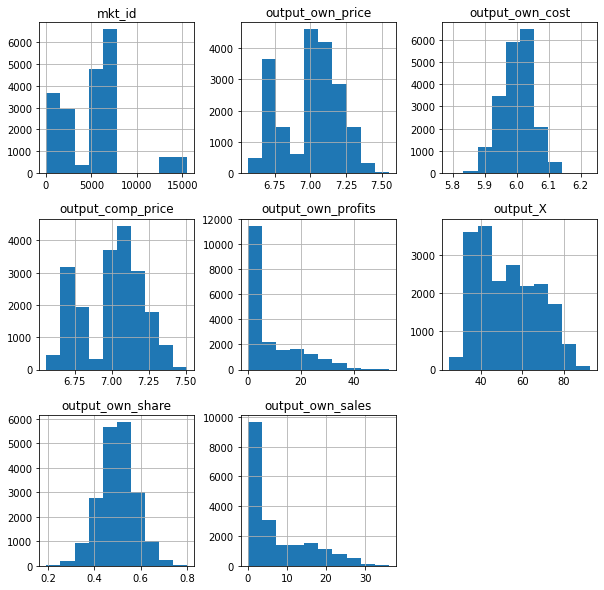

In [ ]:
# Generates a histogram to visualize the distribution and detect any outliers.
p = df.hist(figsize = (10,10))

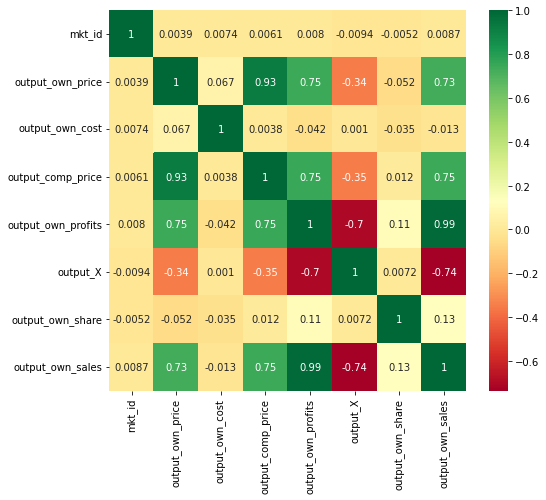

In [ ]:
# Display a heatmap with the correlation between the all variables.
plt.figure(figsize=(8,7)) 
sns.heatmap(df.corr(), annot=True, cmap ='RdYlGn');

This strong correlation suggests that the price of competitors has a significant influence on the company's own price. Therefore, an increase in the price of competitors can lead to an increase in the company's own price, as a way to maintain competitiveness in the market.

In addition, the analysis of correlations between the other columns suggests that the relationship between output_own_profits and output_own_sales is extremely strong, indicating that an increase in the company's own sales has a significant impact on its profits. The positive correlation between output_own_profits and output_own_price suggests that increasing the own price can be an effective strategy to increase profits.

In summary, the correlation analysis indicates that the company's own price is strongly influenced by the price of competitors and that an increase in own sales can lead to a significant increase in profits.

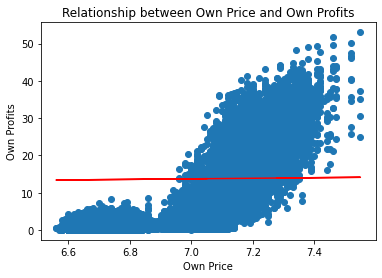

In [131]:
# Creates a scatter plot between 'output_own_price' and 'output_own_profits' 
# The red line plots a line of best fit on the scatter plot, using the correlation 
# between the two columns and the mean of the profits column.
plt.scatter(df['output_own_price'], df['output_own_profits'])
plt.plot(df['output_own_price'], df['output_own_profits'].corr(df['output_own_price'])*df['output_own_price'] + df['output_own_profits'].mean(), color='red')
plt.xlabel('Own Price')
plt.ylabel('Own Profits')
plt.title('Relationship between Own Price and Own Profits')
plt.show()

Based on the analysis of the correlation between 'output_own_profits' and 'output_own_price' and the visualization of the graph showing the relationship between these variables, we can conclude that there is a positive but not so strong correlation between them. As the price of products increases, the company's profit tends to increase as well, up to a certain point, after which the increase in the price of products may not lead to a proportional increase in profits.


We can see that when the price of products is less than <span>&#36;</span>6.90, the maximum profit earned is less than <span>&#36;</span>10. However, when the price of products exceeds <span>&#36;</span>6.90, the profit tends to range between <span>&#36;</span>10 and <span>&#36;</span>40 per period.


This can be due to various factors such as price elasticity, competition in the market, and consumer demand. In general, it is important to find the right balance between the price of the products and the desired profit, considering these factors and the production capacity of the company.

In conclusion, we can say that based on the positive correlation observed between the 'output_own_profits' and 'output_own_price' data, it may be worth considering an increase in product prices to increase the company's profit, but it is important to find a balance between price and consumer demand.

We can conclude that there is seasonality in profits throughout the year, with higher profits generated from November to early March and lower profits for the rest of the year. This can be due to several factors, such as seasonal sales and demand for specific products, changes in raw material prices, vacations, weather conditions, and others. With this information, the company can adjust its pricing and sales strategy according to seasonality to maximize profits.

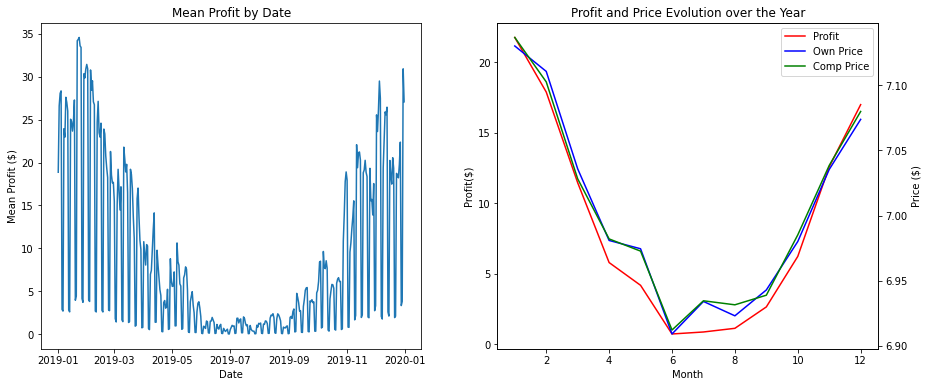

In [4]:
# Display two line plot the first graph is a plot of the average profits over time, 
# while the second graph is a plot that shows the evolution of own and competitor 
# prices relative to profits over the year.

# Group the data by date and calculate the mean profit
profits_by_date = df.groupby('output_date')['output_own_profits'].mean()

# Group the data by month and calculate the mean profit and price
df_monthly = df.groupby(df['output_date'].dt.month).mean()

# Create a figure with two columns and a size of (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))

# Create a line plot of the mean profit by date
ax1.plot(profits_by_date.index, profits_by_date)
ax1.set_title('Mean Profit by Date')
ax1.set_xlabel('Date')
ax1.set_ylabel('Mean Profit ($)')

# Create a line plot of the mean profit and price by month
ax2.plot(df_monthly.index, df_monthly['output_own_profits'], color='red', label='Profit')
ax2.set_title('Profit and Price Evolution over the Year')
ax2.set_xlabel('Month')
ax2.set_ylabel('Profit($)')

# Create the second y-axis for price
ax3 = ax2.twinx()
ax3.plot(df_monthly.index, df_monthly['output_own_price'], color='blue', label='Own Price')
ax3.plot(df_monthly.index, df_monthly['output_comp_price'], color='green', label='Comp Price')
ax3.set_ylabel('Price ($)')

# Add the legends to the plots
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# Display the plot
plt.show()


We can conclude that there is seasonality in profits throughout the year, with higher profits generated from November to early March and lower profits for the rest of the year. This may be due to various factors such as seasonal sales and demand for specific products, changes in raw material prices, holidays, weather conditions, among others. With this information, the company can adjust its pricing and sales strategy according to seasonality to maximize profit.

In [14]:
# Function for detect outliers

def detect_outliers(df, column_list):
    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    # Loop through each column in the specified list
    for column in column_list:
        # Calculate the first quartile (Q1), third quartile (Q3), and interquartile range (IQR) for the column
        Q1 = df_copy[column].quantile(0.25)
        Q3 = df_copy[column].quantile(0.75)
        IQR = Q3 - Q1
        # Calculate the lower and upper bounds for outlier detection
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Find the rows where the value in the column is below the lower bound or above the upper bound
        outliers = df_copy[(df_copy[column] < lower_bound) | (df_copy[column] > upper_bound)]
        # If there are no outliers, print a message indicating so
        if outliers.empty:
            print(f"Column {column} has no outliers")
        # If there are outliers, print a message indicating how many were found
        else:
            print(f"Column {column} has {len(outliers)} outliers")

column_list = ["output_own_price","output_own_cost","output_comp_price","output_own_profits","output_X","output_own_share","output_own_sales"]
detect_outliers(df, column_list)

Column output_own_price has no outliers
Column output_own_cost has 223 outliers
Column output_comp_price has no outliers
Column output_own_profits has 369 outliers
Column output_X has no outliers
Column output_own_share has 263 outliers
Column output_own_sales has 98 outliers


In [15]:
# Remove the outliers

# create a new DataFrame with the same data as the original DataFrame
df_without_outliers = df.copy()

# iterate over each column in column_list
for column in column_list:
    # calculate the quartiles, interquartile range, and lower and upper bounds for the column
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # remove any rows from df_without_outliers where the value in the column is outside the lower and upper bounds
    df_without_outliers = df_without_outliers[(df_without_outliers[column] >= lower_bound) & (df_without_outliers[column] <= upper_bound)]


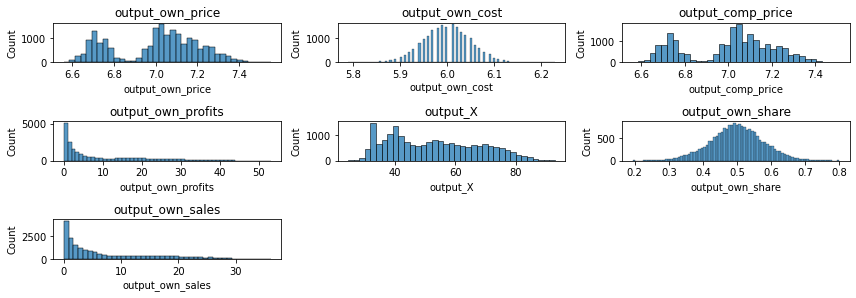

In [ ]:
# Creates a histogram with each column


k=1
plt.figure(figsize=(12,12))
# Iterate over each column in df that has a data type of float64
for i in df.select_dtypes("float64"):
    # Add a subplot with index k to the figure (9 rows x 3 columns)
    plt.subplot(9,3,k)
    # Plot a histogram of the current column using seaborn
    sns.histplot(df[i])
    # Set the title of the current subplot to the name of the current column
    plt.title(i)
    # Increment the index of the current subplot
    k+=1
    # Automatically adjust the spacing between subplots
    plt.tight_layout()
  


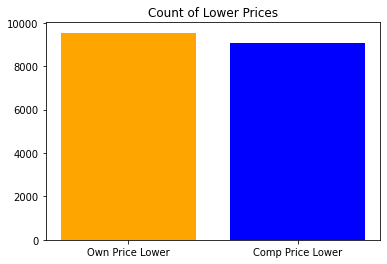

In [5]:
# Create a bar chart that counts the times the own price was lower than the comp price
df['own_price_lower'] = np.where(df['output_own_price'] < df['output_comp_price'], 1, 0)
df['comp_price_lower'] = np.where(df['output_comp_price'] < df['output_own_price'], 1, 0)

own_price_lower_count = df['own_price_lower'].sum()
comp_price_lower_count = df['comp_price_lower'].sum()

plt.bar(['Own Price Lower', 'Comp Price Lower'], [own_price_lower_count, comp_price_lower_count], color=['orange', 'blue'])
plt.title('Count of Lower Prices')
plt.show()

Based on the data above, we can also conclude that there is a significant competition between our company and its competitors, as both our prices and our competitors' prices are constantly changing in order to gain a competitive advantage.

#**TIME SERIES ANALYSIS**

In [62]:
# Display main info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19710 entries, 0 to 19709
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   mkt_id              19710 non-null  int64         
 1   output_date         19710 non-null  datetime64[ns]
 2   output_own_price    19710 non-null  float64       
 3   output_own_cost     19710 non-null  float64       
 4   output_comp_price   19710 non-null  float64       
 5   output_own_profits  19710 non-null  float64       
 6   output_X            19710 non-null  float64       
 7   output_own_share    19710 non-null  float64       
 8   output_own_sales    19710 non-null  float64       
 9   day                 19710 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 1.5 MB


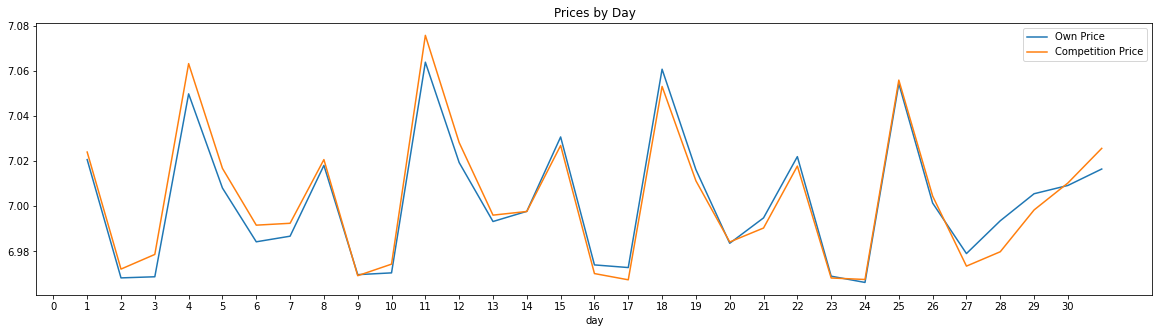

In [9]:
# Plot the average daily prices for the own price and the competition price.
average_by_day=df.groupby('day').mean()
fig,ax=plt.subplots(figsize=(20,5))
ax.xaxis.set(ticks=range(0,31))
average_by_day['output_own_price'].plot(x=df.output_date, label='Own Price', ax=ax)
average_by_day['output_comp_price'].plot(x=df.output_date, label='Competition Price', ax=ax)
plt.title("Prices by Day")
plt.legend()
plt.show()

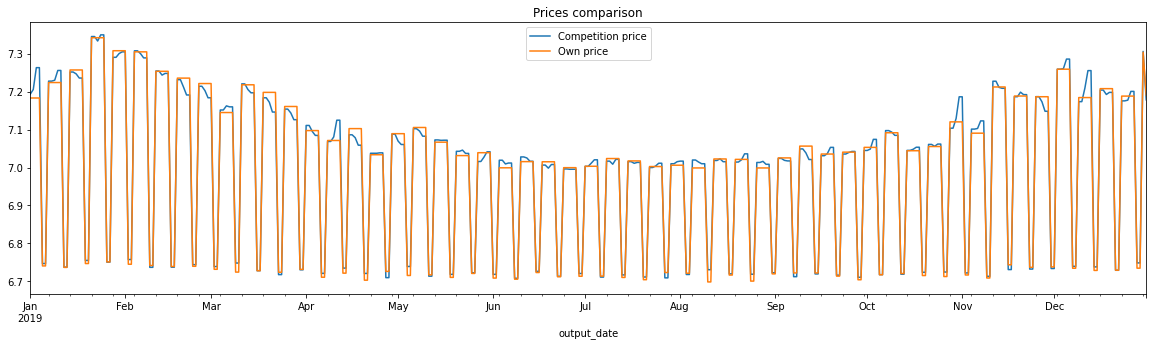

In [10]:
# Plot the comparasion of price between the comp and own price over the year.
average_by_day=df.groupby('output_date').mean()
plt.figure(figsize=(20,5))
average_by_day['output_comp_price'].plot(x=df.output_date, label="Competition price")
average_by_day['output_own_price'].plot(x=df.output_date, label="Own price")
plt.legend()
plt.title("Prices comparison")
plt.show()

#**Feature Selection** 

We will select the best variables to do our training and testing and after selecting we will split the data to train our model.

In [57]:
# Define the predictor and predictive variables
X = df_without_outliers[['mkt_id', 'output_own_profits', 'output_own_cost', 
                         'output_comp_price', 'output_X', "output_own_share", 
                                                          "output_own_sales"]]
y = df_without_outliers['output_own_price']

In [58]:
from sklearn.model_selection import train_test_split

# Split the data in training and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Decision Tree

In [59]:
from sklearn.tree import DecisionTreeRegressor

# Create the model
model1 = DecisionTreeRegressor(random_state=42)
model1.fit(X_train, y_train)

# Making predictions on the test set
pred_model1 = model1.predict(X_test)

# Evaluates the model's performance on the test set
score = model1.score(X_test, y_test)
print(f'Acurácia do modelo: {score:.2f}')

Acurácia do modelo: 0.93


In [60]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds
scores = cross_val_score(model1, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Evaluates the performance of the model on cross-validation
score = model1.score(X_test, y_test)
print(f'Acurácia do modelo: {score:.2f}')

Acurácia do modelo: 0.93


**Random Forest**

In [61]:
from sklearn.ensemble import RandomForestRegressor

# Create the model
model2 = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model2.fit(X_train, y_train)

# Making predictions on the test set
pred_model2 = model2.predict(X_test)

# Evaluates the model's performance on the test set
score = model2.score(X_test, y_test)
print(f'Acurácia do modelo: {score:.2f}')

Acurácia do modelo: 0.97


In [62]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds
scores = cross_val_score(model2, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Evaluates the performance of the model on cross-validation
score = model2.score(X_test, y_test)
print(f'Acurácia do modelo: {score:.2f}')

Acurácia do modelo: 0.97


GRADIENT BOOST

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

# Create the model Gradient Boosting Regressor
model3 = GradientBoostingRegressor(random_state=42)

# Train the model
model3.fit(X_train, y_train)

# Making predictions on the test set
pred_model3 = model3.predict(X_test)

# Evaluates the model's performance on the test set
score = model3.score(X_test, y_test)
print(f'Acurácia do modelo: {score:.2f}')

Acurácia do modelo: 0.94


In [64]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds
scores = cross_val_score(model3, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Evaluates the performance of the model on cross-validation
score = model3.score(X_test, y_test)
print(f'Acurácia do modelo: {score:.2f}')

Acurácia do modelo: 0.94


**KNN(K-Nearest Neighbors)**

In [65]:
from sklearn.neighbors import KNeighborsRegressor

# Create the model
k = 5
model4 = KNeighborsRegressor(n_neighbors=k)

# Train the model
model4.fit(X_train, y_train)

# Making predictions on the test set
pred_model4 = model4.predict(X_test)

# Evaluates the model's performance on the test set
score = model4.score(X_test, y_test)
print(f'Acurácia do modelo: {score:.2f}')

Acurácia do modelo: 0.86


In [66]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds
scores = cross_val_score(model4, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Evaluates the performance of the model on cross-validation
score = model4.score(X_test, y_test)
print(f'Acurácia do modelo: {score:.2f}')

Acurácia do modelo: 0.86


In [67]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error 

#Function to evaluate the model
def evaluate_model(model, y_test, pred_model):
    mse = mean_squared_error(y_test, pred_model)
    mae = mean_absolute_error(y_test, pred_model)
    r2 = r2_score(y_test, pred_model)
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'R-squared (R2): {r2:.4f}')


In [68]:
# Show the evaluation result.
print(f"{'Decision Tree':>21}")
evaluate_model(model1, y_test, pred_model1)
print("-----------------------------------")
print(f"{'Random Forest':>21}")
evaluate_model(model2, y_test, pred_model2)
print("-----------------------------------")
print(f"{'XGBOOST':>18}")
evaluate_model(model3, y_test, pred_model3)
print("-----------------------------------")
print(f"{'KNN':>16}")
evaluate_model(model4, y_test, pred_model4)

        Decision Tree
Mean Squared Error (MSE): 0.0028
Mean Absolute Error (MAE): 0.0389
R-squared (R2): 0.9282
-----------------------------------
        Random Forest
Mean Squared Error (MSE): 0.0013
Mean Absolute Error (MAE): 0.0269
R-squared (R2): 0.9654
-----------------------------------
           XGBOOST
Mean Squared Error (MSE): 0.0024
Mean Absolute Error (MAE): 0.0374
R-squared (R2): 0.9388
-----------------------------------
             KNN
Mean Squared Error (MSE): 0.0056
Mean Absolute Error (MAE): 0.0545
R-squared (R2): 0.8572


Based on the metrics (MSE, MAE, R-squared) shown above for each model

- Random Forest had the best performance, with the lowest MSE and MAE and the highest R-squared value. This means that the model was able to predict the target variable (output_own_price) with the least amount of error and the highest accuracy, compared to the other models tested.
- Decision Tree and XGBoost also had good performance, with relatively low errors and high R-squared values, but not as good as Random Forest.
- KNN had the worst performance among the models tested, with the highest errors and lowest R-squared value. This suggests that KNN may not be the best model for this particular dataset and problem.

In [77]:
X_test

,mkt_id,output_own_profits,output_own_cost,output_comp_price,output_X,output_own_share,output_own_sales
10768,5371,1.397000,5.95,6.98,69.98,0.437686,1.27
2602,167,1.531801,6.02,6.76,40.64,0.457120,2.07
6747,3875,0.346500,5.96,7.02,86.00,0.602664,0.35
4302,2261,5.428101,6.02,7.05,55.22,0.464603,5.27
7133,4887,0.930000,6.00,6.98,74.12,0.453485,0.93
...,...,...,...,...,...,...,...
5667,2700,0.791800,6.00,6.99,71.96,0.402634,0.74
18887,13777,4.704001,6.00,7.17,57.02,0.473612,4.48
7825,4911,0.929200,6.05,6.95,73.22,0.536716,0.92
2682,167,6.049499,6.01,7.09,55.94,0.524400,5.55


##Making predictions with the trained model

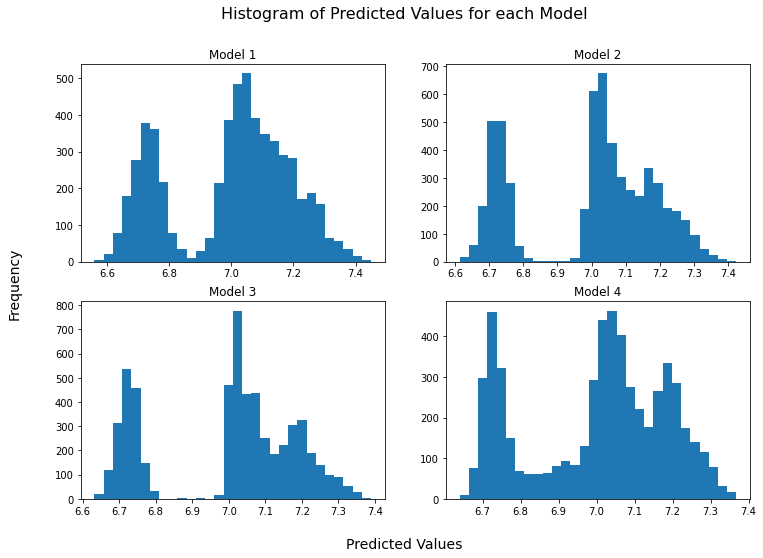

In [69]:
# Create a plot with values predicted for each model
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, ax in enumerate(axs.flat):
    pred_values = [pred_model1, pred_model2, pred_model3, pred_model4][i]
    ax.hist(pred_values, bins=30)
    ax.set_title(f"Model {i+1}")
    
fig.text(0.5, 0.04, 'Predicted Values', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)
fig.suptitle("Histogram of Predicted Values for each Model", fontsize=16)

plt.show()


In [70]:
def predict_price(X_new, train_model):
    # Make predictions using the trained model
    y_pred = model2.predict(X_new)
    return y_pred

In [74]:
# Using the function predict_price
y_pred=predict_price(X_test,model4)
y_pred

array([7.0484, 6.7438, 6.9754, ..., 7.0216, 7.0805, 7.1177])

In [79]:
# Save predict in a CSV file
predictions = pd.DataFrame(y_pred)
predictions.to_csv('predict.csv')